# Trotterized Ising Time Evolution driven by Seizure Data

In [23]:
import numpy as np
import math
from math import acos
import os
import re
import matplotlib.pyplot as plt

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Pauli, SparsePauliOp


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


service = QiskitRuntimeService()

In [24]:
a4 = np.loadtxt('quantum_rolling_output_MST4.txt', skiprows=1)
a4 = a4[:,1]

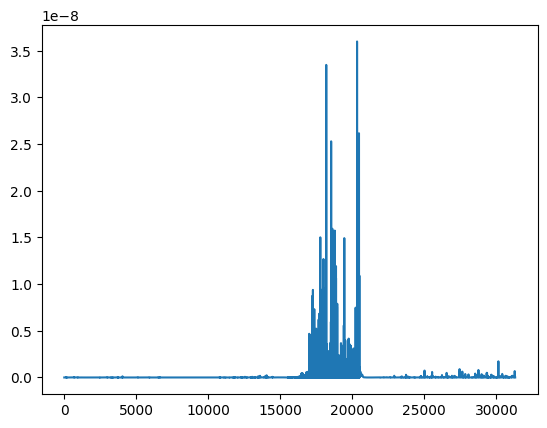

In [37]:
plt.plot(a4)
plt.show()

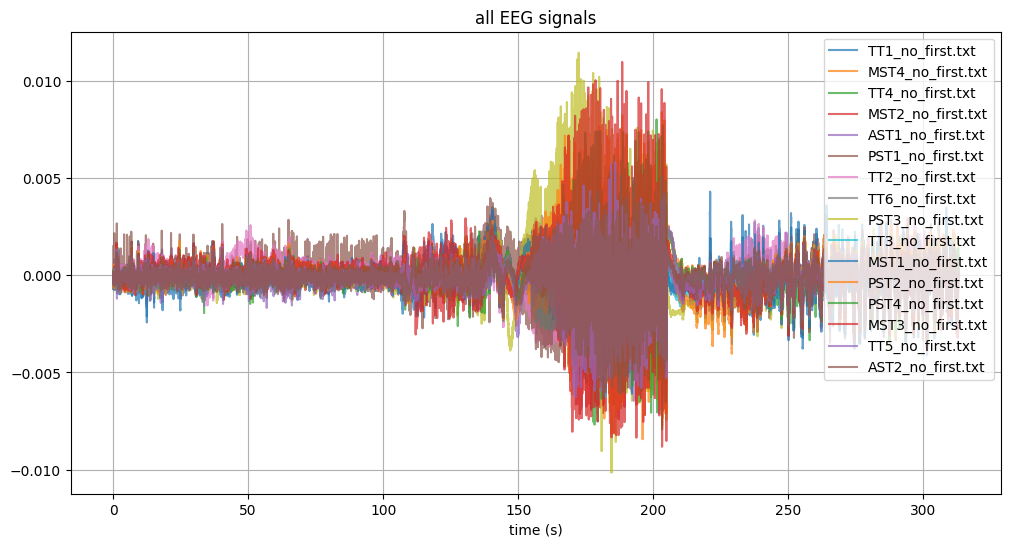

In [26]:
folder_path = '../channels_for_sonification'  

data = []
filenames = []
for file in os.listdir(folder_path):
    filenames.append(file)
    file_path = os.path.join(folder_path, file)
    dataset = np.loadtxt(file_path, skiprows=1)
    data.append(dataset)

plt.figure(figsize=(12, 6))

for i, datensatz in enumerate(data):
    time = datensatz[:, 0]
    signal = datensatz[:, 1]
    plt.plot(time, signal, label=f'{filenames[i]}', alpha=0.7)

plt.title("all EEG signals")
plt.xlabel("time (s)")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [27]:
for i, d in enumerate(data):
    print(f"Datensatz {i+1}: Shape {d.shape}")

min_len = min(d.shape[0] for d in data)
signals_only = np.array([d[:min_len, 1] for d in data])  # keep only signal vector, omit time vector
print('size of the whole data matrix: ', signals_only.shape)  

Datensatz 1: Shape (313110, 2)
Datensatz 2: Shape (313110, 2)
Datensatz 3: Shape (313110, 2)
Datensatz 4: Shape (313110, 2)
Datensatz 5: Shape (313110, 2)
Datensatz 6: Shape (313110, 2)
Datensatz 7: Shape (313110, 2)
Datensatz 8: Shape (313111, 2)
Datensatz 9: Shape (313110, 2)
Datensatz 10: Shape (313110, 2)
Datensatz 11: Shape (313110, 2)
Datensatz 12: Shape (313110, 2)
Datensatz 13: Shape (313110, 2)
Datensatz 14: Shape (313110, 2)
Datensatz 15: Shape (313111, 2)
Datensatz 16: Shape (313110, 2)
size of the whole data matrix:  (16, 313110)


# Transverse field $h_x$

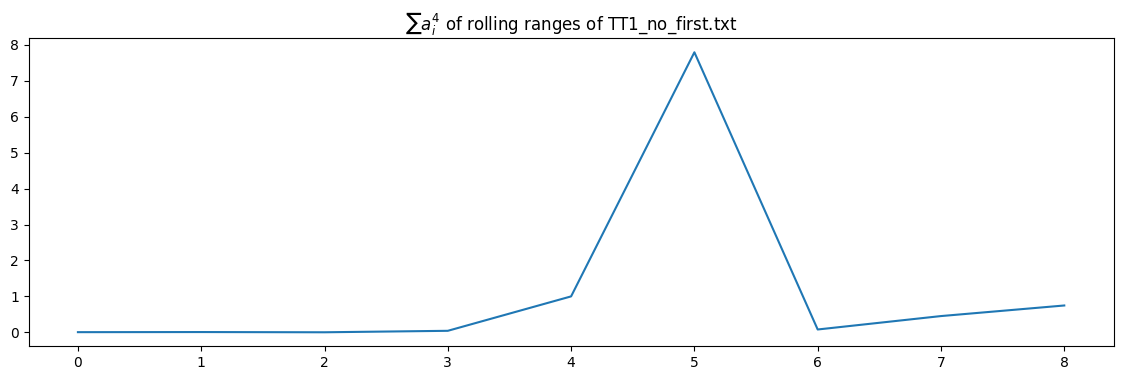

In [28]:
roll=[]
for time in range(0,len(a4) - 3477, 3478):
    # print(time)
    
    vector = a4[time:time+3478]
    vector_norm = np.linalg.norm(vector)  # if we do it quantum, we need to normalize the vector but save the norm so that we can rescale
    if vector_norm == 0:
        roll.append(0)
        continue
    vector = vector / vector_norm
    classical_sum4 = np.sum(vector)
    roll.append(classical_sum4* vector_norm)
roll = (roll/np.linalg.norm(roll))
roll /= roll[4]# roll[4] is at the phase transition
plt.figure(figsize=(14,4))
plt.plot(roll)
plt.title(rf'$\sum a_i^4$ of rolling ranges of {filenames[0]}')
plt.show()
# roll

# Coupling Coefficients J

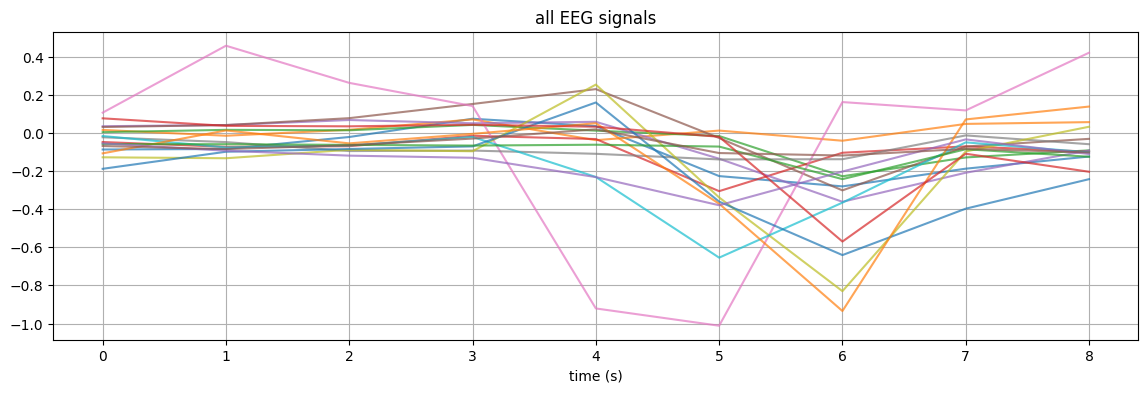

In [29]:
# almost the same lines as above
J_lists = []
for k in range(signals_only.shape[0]):
    rolling_sum4 = []
    for time in range(0,signals_only.shape[1] - 34789, 34790):
        # print(time)
        vector = signals_only[k, time:time+34790]
        vector_norm = np.linalg.norm(vector)  # if we do it quantum, we need to normalize the vector but save the norm so that we can rescale
        if vector_norm == 0:
            rolling_sum4.append(0)
            continue
        vector = vector / vector_norm
        classical_sum4 = np.sum(vector)
        rolling_sum4.append(classical_sum4* vector_norm/50)  #division by 10 for more interesting Ising coefficients
    J_lists.append(rolling_sum4) 
    

plt.figure(figsize=(14, 4))

for i, signal in enumerate(J_lists):
    # time = datensatz[:, 0]
    # signal = datensatz[:, 1]
    plt.plot(signal, label=f'{filenames[i]}', alpha=0.7)

plt.title("all EEG signals")
plt.xlabel("time (s)")
# plt.legend(loc='upper right')
plt.grid(True)
plt.show()



In [30]:
def time_evolution_Ising(N:int, J_list:list, hz_list:list, hx_list:list, dt:float) -> QuantumCircuit:
    """Time evolution circuit for the Ising model with open boudary conditions: H = \sum J_n * Z_n Z_{n+1} + \sum h_n * Z_n + \sum h_n * X_n
    Args:
        N: number of qubits
        J_list: interacting couplings for each nearest neighbor
        hz_list: interacting couplings for Z_n for each qubit
        hx_list: interacting couplings for X_n for each qubit
        dt: time step
    Returns:
        circ_dt: QuantumCircuit of the time evolution
    """

    # print(f'number of qubits: {N}')
    q = QuantumRegister(N)
    circ_dt = QuantumCircuit(q)



    ## \PI_n exp(-it * J[n] * Z_n Z_{n+1})
    # n_eo_list: the orders for the two qubits gates, run the two-qubit gates of (n, n+1) for all even n in parallel; then  run the gates of (n, n+1) for all odd n
    n_eo_list = list(range(0, N-1, 2)) + list(range(1, N, 2))
    for n in n_eo_list:
        circ_dt.cx(q[n], q[(n+1)%N])
        circ_dt.rz(2*dt*J_list[n], q[(n+1)%N])
        circ_dt.cx(q[n], q[(n+1)%N])

    ## \PI_n exp(-it * hx[n] * X_n) exp(-it * hz[n] * Z_n)
    for n in range(N):
        circ_dt.rz(2*dt*hz_list[n], q[n])
        circ_dt.rx(2*dt*hx_list[n], q[n])

    # k = 0
    # for i in range(N):
    #     for j in range(i+1, N):
    #         circ_dt.cx(q[i], q[j])
    #         circ_dt.rz(2*dt*J_list[k], q[j])
    #         circ_dt.cx(q[i], q[j])
    #         k+=1


    return circ_dt

In [34]:
##INPUT PARAMS
N = 16   ### number of qubits
dt = 0.5  ### time step
T =dt*9#3  ### total running time
#backend=FakeSherbrooke()
# backend = AerSimulator.from_backend(service.backend('ibm_sherbrooke'))
backend = AerSimulator()
#backend = service.backend('ibm_kyoto')
filename_preamble='data_seizure_'+backend.name
path='./'
#Make sure that the data directory is in the parent directory of this script
# path = os.path.join(os.path.dirname(os.path.dirname(os.path.realpath(__file__))), 'data')

In [32]:
def get_latest_index():
    files = os.listdir(path)
    pattr = re.compile(filename_preamble+r'_(\d+)')
    indexes = [int(pattr.match(file).group(1)) for file in files if pattr.match(file)]
    if len(indexes) == 0:
        return 0
    else:
        return max(indexes)


In [35]:
### run
for r in range(1):



    tk_list = np.zeros((round(T/dt), N))  ### instore the color index list for each time slice
    #circ = initial_state_ry(N, C, k_list)   ### initial state encode 12 colors according to k_list

    circ = QuantumCircuit(N)
    circ_dt=[]
    for k in range(9):
        hz_list=[0.0]*16
        hx_list=[roll[k]]*16
        J_list=[x[k] for x in J_lists]
        # print(f'Hx: {hx_list}')
        # print(f'J: {J_list}')
        
        circ_dt.append(time_evolution_Ising(N, J_list, hz_list, hx_list, dt))
    ### start time evolution
    # print(circ_dt)
    # raise ValueError
    op_list = []
    for n in range(N):
        op_list.append(SparsePauliOp('I'*(N-n-1) + 'Z' + 'I'*n))

    circ = circ.compose(circ_dt[0])
    
    with Session(service=service, backend=backend) as session:

        for step in range(round(T/dt)):
            print('step: ', step)
            t = round( dt * step )

            pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
            # print(circ.draw(output='text'))
            isa_circuit = pm.run(circ)
            isa_observables = []
            for op in op_list:
                isa_observables.append(op.apply_layout(isa_circuit.layout))
            estimator = Estimator(mode=session)
            

            
            job = estimator.run([(isa_circuit, isa_observables)])

            
            result = job.result()

            datas = []
            
            for n in range(N):              
                
                op_exp =result[0].data.evs[n]
                datas.append(result[0].data)
                k_tn = (1-op_exp)/2
                tk_list[step, n] =  k_tn

            
            # print(k_tn)
            # print(result2[0].data.meas.get_counts())
            if step<round(T/dt)-1:
                print(f'next_step: {step+1}')
                circ = circ.compose(circ_dt[step+1])
            # flat_sorted_indices = np.argsort(tk_list[step,:], axis=None)
            # tk_list[step,:] = flat_sorted_indices
            print(f'tk_list: {tk_list[step,:]}')
        session.close()


    filename = f'{path}/{filename_preamble}_{get_latest_index() +1}_obs.txt'

    # print(tk_list)
    for k in tk_list:
        with open(filename, 'a') as f:
            f.write(','.join(['{:0.4f}'.format(i) for i in k]) + '\n')



    

    

/tmp/ipykernel_1961967/1844732851.py:28: DeprecationWarning: The service parameter is deprecated as of qiskit-ibm-runtime 0.26.0 and will be removed no sooner than 3 months after the release date. The service can be extracted from the backend object so it is no longer necessary.
  with Session(service=service, backend=backend) as session:


step:  0
next_step: 1
tk_list: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00024414 0.         0.        ]
step:  1
next_step: 2
tk_list: [0.00024414 0.         0.         0.         0.         0.00024414
 0.         0.         0.         0.         0.00048828 0.
 0.         0.         0.         0.        ]
step:  2
next_step: 3
tk_list: [0.         0.00024414 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00024414 0.         0.         0.        ]
step:  3
next_step: 4
tk_list: [0.00048828 0.00073242 0.00097656 0.00097656 0.00048828 0.00024414
 0.0012207  0.00097656 0.00073242 0.00146484 0.00073242 0.00073242
 0.00024414 0.00097656 0.         0.00073242]
step:  4
next_step: 5
tk_list: [0.24707031 0.2565918  0.25390625 0.26391602 0.24462891 0.25170898
 0.25097656 0.25512695 0.25708008 0.2590332  0.2512207  0.25073242
 0.24487305 0.26147461 0.253173

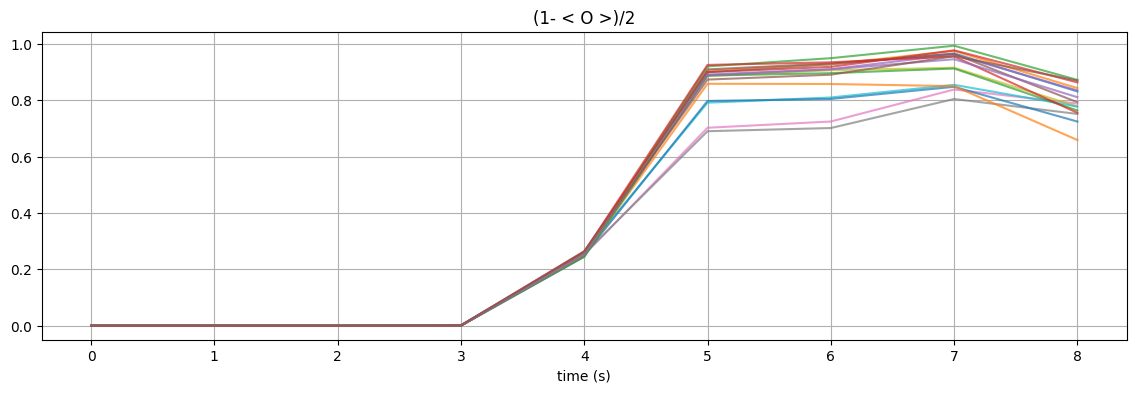

In [36]:
plt.figure(figsize=(14, 4))

for i, signal in enumerate(np.transpose(tk_list)):
    # time = datensatz[:, 0]
    # signal = datensatz[:, 1]
    plt.plot(signal, label=f'{filenames[i]}', alpha=0.7)

plt.title("(1- < O >)/2")
plt.xlabel("time (s)")
# plt.legend(loc='upper right')
plt.grid(True)
plt.show()